In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import matplotlib as mpl
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

data_dir = '../input/dataset/training'

train_val_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        validation_split=0.2,
                                        preprocessing_function=preprocess_input)

train_gen = train_val_data_gen.flow_from_directory(directory=data_dir,
                                                   target_size=(256,256),
                                                   color_mode='rgb',
                                                   classes=None,
                                                   class_mode='categorical',
                                                   batch_size=32,
                                                   shuffle=True,
                                                   seed=seed,
                                                   subset='training')
val_gen = train_val_data_gen.flow_from_directory(directory=data_dir,
                                                 target_size=(256,256),
                                                 color_mode='rgb',
                                                 classes=None,
                                                 class_mode='categorical',
                                                 batch_size=32,
                                                 shuffle=True,
                                                 seed=seed,
                                                 subset='validation')

Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.


In [ ]:
input_shape = (256, 256, 3)
epochs = 100

In [ ]:
conv_Xception = tfk.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)
conv_Xception.summary()

2021-11-27 16:42:44.787803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 16:42:44.938477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 16:42:44.939247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 16:42:44.940806: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________

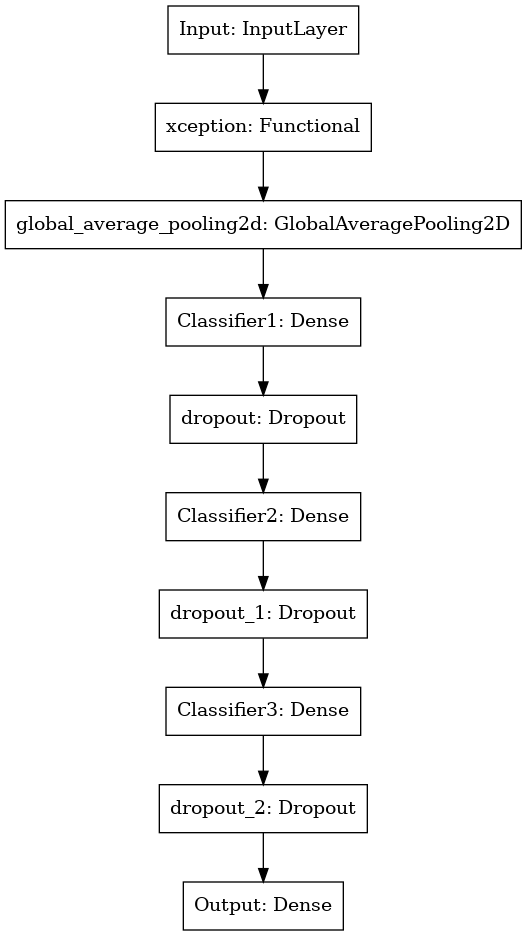

In [ ]:
input_layer = tfk.Input(shape=input_shape, name='Input')
conv = conv_Xception(input_layer)
global_pooling = tfkl.GlobalAveragePooling2D()(conv)
classifier_layer1 = tfkl.Dense(units=512, name='Classifier1', kernel_initializer=tfk.initializers.GlorotUniform(seed), kernel_regularizer=tfk.regularizers.l2(1e-5), activation='relu')(global_pooling)
classifier_layer1 = tfkl.Dropout(0.3, seed=seed)(classifier_layer1)
classifier_layer2 = tfkl.Dense(units=256, name='Classifier2', kernel_initializer=tfk.initializers.GlorotUniform(seed), kernel_regularizer=tfk.regularizers.l2(1e-5), activation='relu')(classifier_layer1)
classifier_layer2 = tfkl.Dropout(0.3, seed=seed)(classifier_layer2)
classifier_layer3 = tfkl.Dense(units=128, name='Classifier3', kernel_initializer=tfk.initializers.GlorotUniform(seed), kernel_regularizer=tfk.regularizers.l2(1e-5), activation='relu')(classifier_layer2)
classifier_layer3 = tfkl.Dropout(0.3, seed=seed)(classifier_layer3)
output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer3)

complete_model = tfk.Model(inputs=input_layer, outputs=output_layer, name='Xception')
tfk.utils.plot_model(complete_model)

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

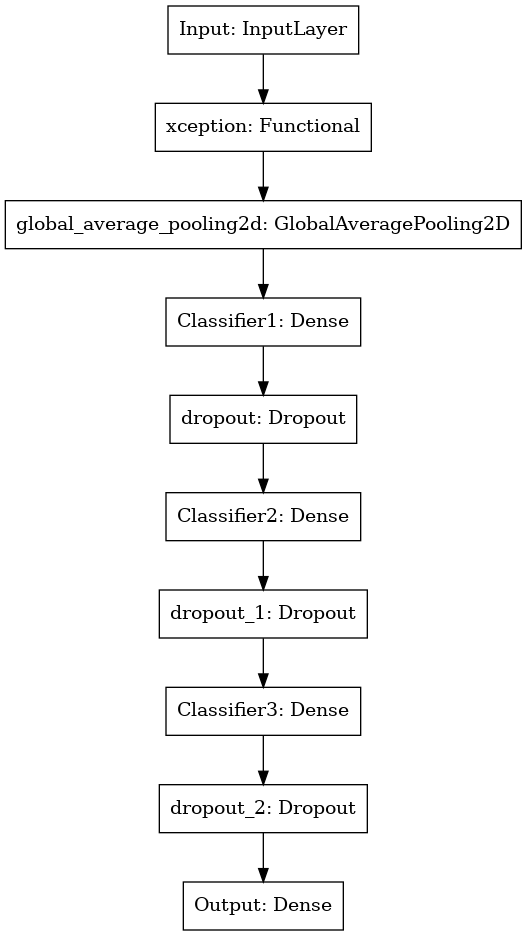

In [ ]:
# Training last 10 layers
for i, layer in enumerate(complete_model.get_layer('xception').layers[:115]):
    layer.trainable=False
for i, layer in enumerate(complete_model.get_layer('xception').layers):
    print(i, layer.name, layer.trainable)

# Compile the model
complete_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-5), metrics='accuracy')
complete_model.summary()
tfk.utils.plot_model(complete_model)

In [ ]:
patience = 15
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)

In [ ]:
checkpoint_path = 'training_Xception/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=False,
                                                verbose=1)

In [ ]:
complete_history = complete_model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = val_gen,
    callbacks = [early_stopping, cp_callback]
).history

2021-11-27 16:42:51.980709: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-11-27 16:42:56.192161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


444/444 [==============================] - 327s 713ms/step - loss: 2.1007 - accuracy: 0.3389 - val_loss: 1.7250 - val_accuracy: 0.5027

Epoch 00001: saving model to training_Xception/cp.ckpt
Epoch 2/100
444/444 [==============================] - 287s 648ms/step - loss: 1.4159 - accuracy: 0.6007 - val_loss: 1.0874 - val_accuracy: 0.6889

Epoch 00002: saving model to training_Xception/cp.ckpt
Epoch 3/100
444/444 [==============================] - 287s 647ms/step - loss: 0.9005 - accuracy: 0.7372 - val_loss: 0.6865 - val_accuracy: 0.8019

Epoch 00003: saving model to training_Xception/cp.ckpt
Epoch 4/100
444/444 [==============================] - 282s 636ms/step - loss: 0.6278 - accuracy: 0.8252 - val_loss: 0.5400 - val_accuracy: 0.8452

Epoch 00004: saving model to training_Xception/cp.ckpt
Epoch 5/100
444/444 [==============================] - 277s 623ms/step - loss: 0.4589 - accuracy: 0.8724 - val_loss: 0.3739 - val_accuracy: 0.8858

Epoch 00005: saving model to training_Xception/cp.ck

In [ ]:
complete_model.save('saved_model')

2021-11-28 00:19:11.410456: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


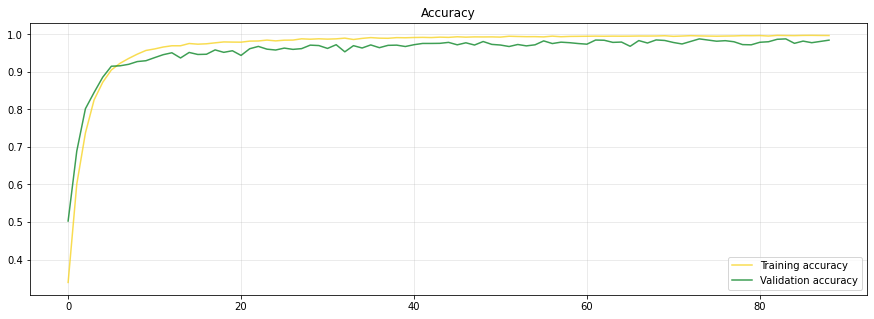

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(complete_history['accuracy'], label='Training accuracy', alpha=.8, color='#F7D426')
plt.plot(complete_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#0E8729')
plt.title('Accuracy')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.savefig('Xception.png')
plt.show()